# Homework 4: Unsupervised Learning

## Exercise 1: Compute the SVD of a Matrix & Verify the Reconstruction


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

rng = np.random.default_rng(211)

The difference between A and its reconstruction: 6.13e-15


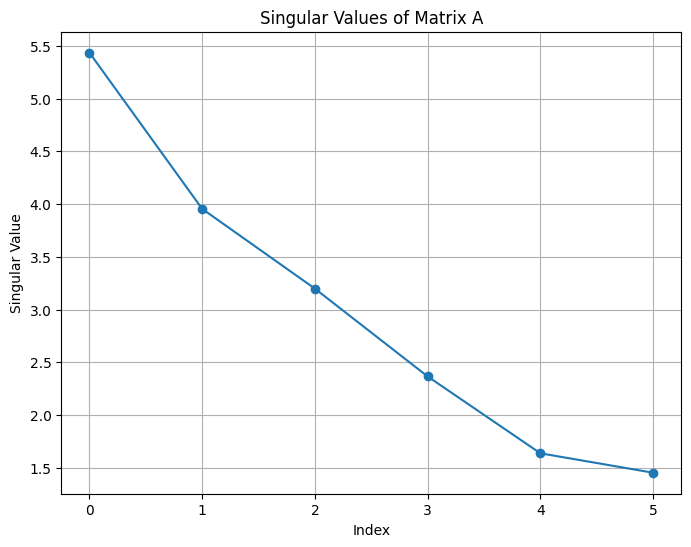

In [ ]:
m, n = 10, 6
A = rng.standard_normal((m, n))
U, s, Vt = np.linalg.svd(A, full_matrices=False)

sigma = np.diag(s)
A_reconstructed = U @ sigma @ Vt

normal_difference = np.linalg.norm(A - A_reconstructed)
print(f"The difference between A and its reconstruction: {normal_difference:.2e}")

plt.figure(figsize=(8, 6))
plt.plot(s, 'o-')
plt.title('Singular Values of Matrix A')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid()
plt.show()

## Exercise 2: Best Rank-$k$ Approximation

Rank-1 approximation error: 6.02e+00
Rank-2 approximation error: 4.54e+00
Rank-3 approximation error: 3.22e+00
Rank-4 approximation error: 2.19e+00
Rank-5 approximation error: 1.45e+00
Rank-6 approximation error: 6.13e-15


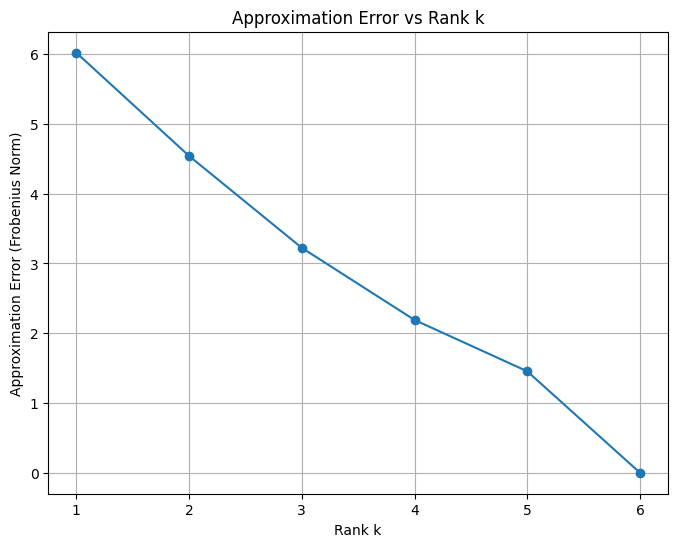

In [ ]:
def rank_k_approximation(A, k):
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    sigma_k = np.diag(s[:k])
    U_k = U[:, :k]
    Vt_k = Vt[:k, :]
    A_k = U_k @ sigma_k @ Vt_k
    return A_k

errors = []
for k in range(1, 7):
    A_k = rank_k_approximation(A, k)
    error = np.linalg.norm(A - A_k)
    print(f"Rank-{k} approximation error: {error:.2e}")
    errors.append(error)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 7), errors, 'o-')
plt.title('Approximation Error vs Rank k')
plt.xlabel('Rank k')
plt.ylabel('Approximation Error (Frobenius Norm)')
plt.grid()
plt.show()


## Exercise 3: Image Compression with SVD

In [ ]:
import skimage

# Loading the "cameraman" image
x = skimage.data.camera()

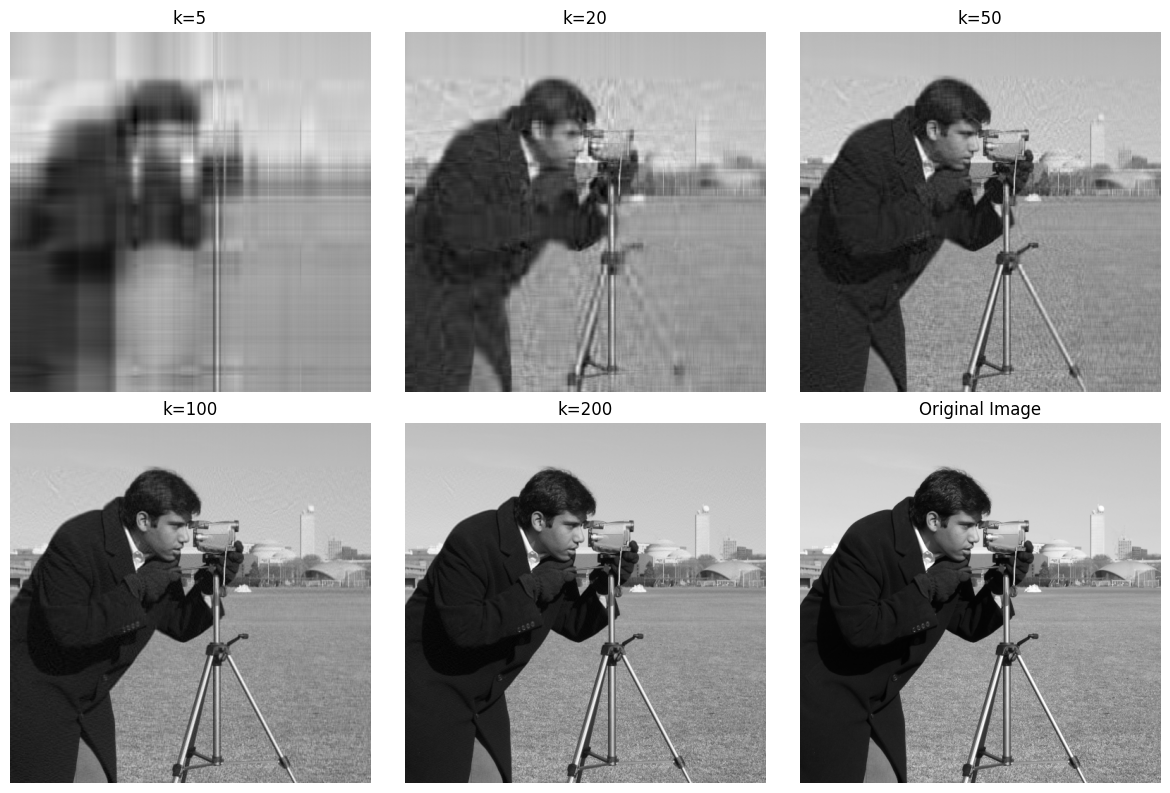

In [ ]:
u, s, vt = np.linalg.svd(x, full_matrices=False)
def svd_reconstruct(u, s, vt, k):
    """Reconstruct image using top k singular values/vectors."""
    s_k = np.zeros_like(s)
    s_k[:k] = s[:k]
    sigma_k = np.diag(s_k)
    return u @ sigma_k @ vt

ks = [5, 20, 50, 100, 200]
reconstructed_images = [svd_reconstruct(u, s, vt, k) for k in ks]
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()
for i, k in enumerate(ks):
    axes[i].imshow(reconstructed_images[i], cmap='gray')
    axes[i].set_title(f'k={k}')
axes[5].imshow(x, cmap='gray')
axes[5].set_title('Original Image')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def compression_factor(original_shape, k):
    m, n = original_shape
    original_size = m * n
    compressed_size = k * (m + n + 1)
    return compressed_size / original_size

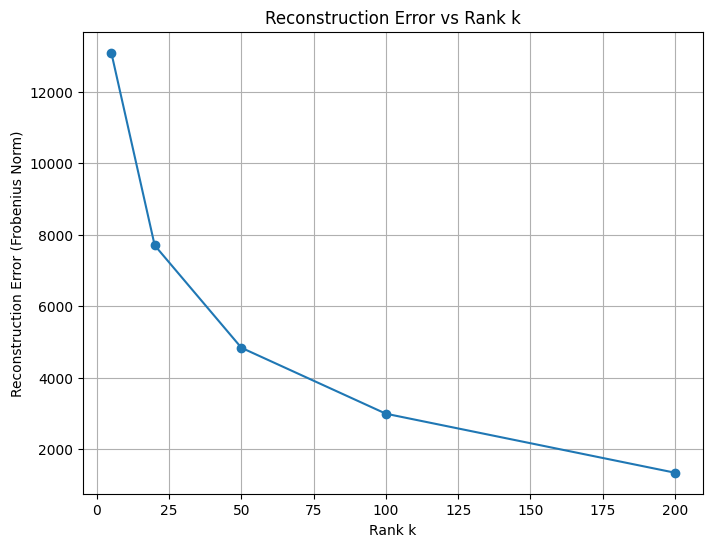

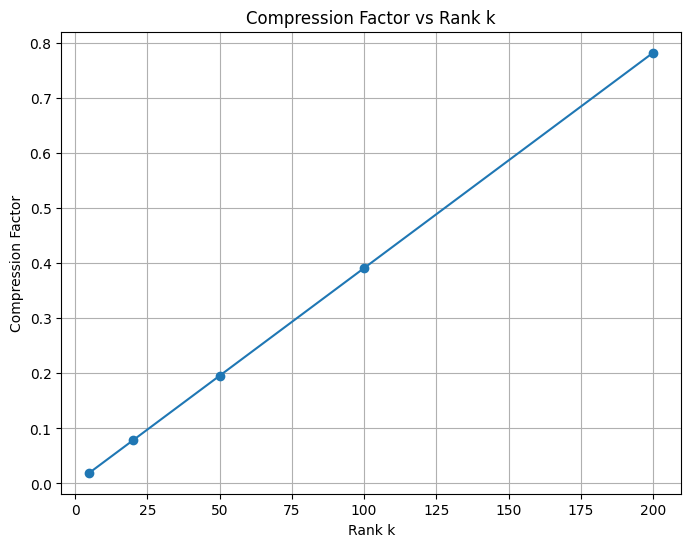

In [ ]:
reconstruction_errors = [np.linalg.norm(x - img) for img in reconstructed_images]
plt.figure(figsize=(8, 6))
plt.plot(ks, reconstruction_errors, 'o-')
plt.title('Reconstruction Error vs Rank k')
plt.xlabel('Rank k')
plt.ylabel('Reconstruction Error (Frobenius Norm)')
plt.grid()
plt.show()

compression_factors = [compression_factor(x.shape, k) for k in ks]
plt.figure(figsize=(8, 6))
plt.plot(ks, compression_factors, 'o-')
plt.title('Compression Factor vs Rank k')
plt.xlabel('Rank k')
plt.ylabel('Compression Factor')
plt.grid()
plt.show()

## Exercise 5: PCA + Clustering on a Real Dataset

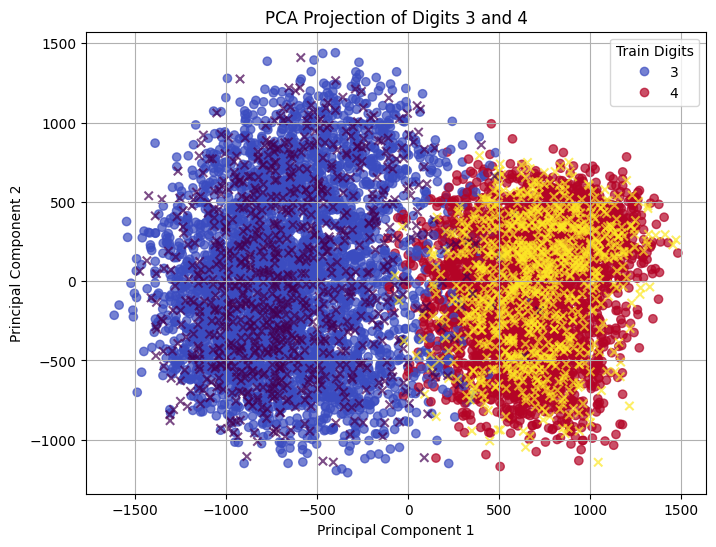

In [ ]:
df = pd.read_csv('train.csv')

x_features = df.iloc[:, 1:].values
y_labels = df.iloc[:, 0].values

mask = (y_labels == 3) | (y_labels == 4)
x_34 = x_features[mask]
y_34 = y_labels[mask]

n_train = int(len(y_34) * 0.8)
idx = np.arange(len(y_34))
rng.shuffle(idx)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

x_train, x_test = x_34[train_idx], x_34[test_idx]
y_train, y_test = y_34[train_idx], y_34[test_idx]

x_train_c = x_train - np.mean(x_train, axis=0)
x_test_c = x_test - np.mean(x_train, axis=0)

u, s, vt = np.linalg.svd(x_train_c, full_matrices=False)
k = 2
v2 = vt[:k]

z_train = x_train_c @ v2.T
z_test = x_test_c @ v2.T

plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_train[:, 0], z_train[:, 1], c=y_train, cmap="coolwarm", alpha=0.7, label='Train')
plt.legend(*scatter.legend_elements(), title="Train Digits")
scatter = plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test, alpha=0.7, marker='x', label='Test')
plt.title('PCA Projection of Digits 3 and 4')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

## Exercise 6: Classification After PCA: Linear Classifier and Centroid Classifier

In [5]:
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1/(1+np.exp(-z))

def bce_loss(theta, x, y):
    p = sigmoid(x @ theta)
    epsilon = 1e-15
    p = np.clip(p, epsilon, 1 - epsilon)
    # Binary Cross Entropy Loss
    return -(y*np.log(p) + (1-y)*np.log(1-p)).mean()

def grad_bce_loss(theta, x, y):
    # Gradient of bce loss
    return (x.T @ (sigmoid(x @ theta) - y)) / len(y)

def accuracy(theta, x, y):
    preds = sigmoid(x @ theta) >= 0.5
    return (preds == y).mean()

def train_sgd(l, grad_l, x, y, lr=0.1, epochs=200, batch_size=32, full_loss=False):
    N, d = x.shape
    theta = np.zeros((d, 1))
    losses, accs = [], []

    for epoch in range(epochs):
        # Shuffle data
        idx = np.arange(len(x))
        rng.shuffle(idx)

        x_shuffled = x[idx, :]
        y_shuffled = y[idx]

        for batch in range(0, N, batch_size):
            grad = grad_l(theta,
                             x_shuffled[batch:batch + batch_size, :],
                             y_shuffled[batch:batch + batch_size, :])
            theta -= lr * grad

        if full_loss:
            # Log full-dataset metrics after the epoch
            losses.append(l(theta, x, y))
            accs.append(accuracy(theta, x, y))
        else:
            # Log mini-batch metrics after the epoch
            losses.append(l(theta,
                             x_shuffled[0:batch_size, :],
                             y_shuffled[0:batch_size, :]))
            accs.append(accuracy(theta,
                                 x_shuffled[0:batch_size, :],
                                 y_shuffled[0:batch_size, :]))

    return theta, np.array(losses), np.array(accs)

def evaluate_metrics(theta, X, y, threshold):
    y_prob = sigmoid(X @ theta)
    y_pred = (y_prob >= threshold).astype(int)

    # Confusion Matrix Elements
    TP = np.sum((y_pred == 1) & (y == 1))
    TN = np.sum((y_pred == 0) & (y == 0))
    FP = np.sum((y_pred == 1) & (y == 0))
    FN = np.sum((y_pred == 0) & (y == 1))
    accuracy = (TP + TN) / len(y)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "Threshold": threshold,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "Conf Matrix": [[TP, FP], [FN, TN]] # [[Pred Pos/Act Pos, Pred Pos/Act Neg], ...]
    }

def print_confusion_matrix(conf_matrix):
    print("Confusion Matrix:")
    print(f"                    Predicted Positive   Predicted Negative")
    print(f"Actual Positive      {conf_matrix[0][0]}                  {conf_matrix[1][0]}")
    print(f"Actual Negative      {conf_matrix[0][1]}                  {conf_matrix[1][1]}")


(theta_0, theta_1, theta_bias): [ 0.05749361 -0.02035943 -7.5302284 ]
Accuracy: 0.9721
Precision: 0.9627
Recall: 0.9821
Confusion Matrix:
                    Predicted Positive   Predicted Negative
Actual Positive      825                  15
Actual Negative      32                  813


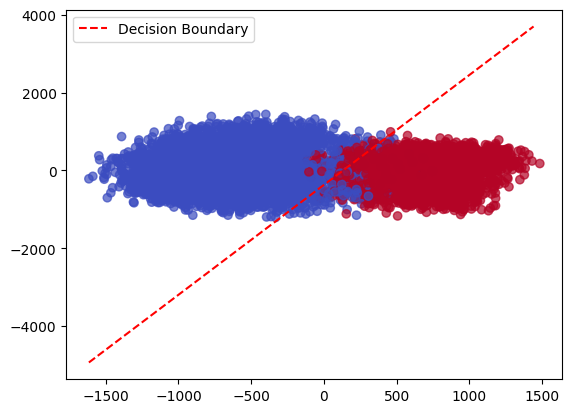

In [ ]:
x = np.hstack((z_train, np.ones((z_train.shape[0], 1))))
y = (y_train == 4).astype(int).reshape(-1, 1)

theta_sgd, loss_sgd, acc_sgd = train_sgd(
    bce_loss, grad_bce_loss,
    x, y,
    lr=1e-3,
    epochs=2000,
    batch_size=32,
    full_loss=True
)

print("(theta_0, theta_1, theta_bias):", theta_sgd.ravel())

result = evaluate_metrics(theta_sgd, np.hstack((z_test, np.ones((z_test.shape[0], 1)))), (y_test == 4).astype(int).reshape(-1, 1), threshold=0.5)
print(f"Accuracy: {result['Accuracy']:.4f}")
print(f"Precision: {result['Precision']:.4f}")
print(f"Recall: {result['Recall']:.4f}")
print_confusion_matrix(result["Conf Matrix"])

x0_values = np.array([z_train[:, 0].min(), z_train[:, 1].max()])
x1_values = -(theta_sgd[2] + theta_sgd[0] * x0_values) / theta_sgd[1]
plt.plot(x0_values, x1_values, 'r--', label='Decision Boundary')

plt.scatter(z_train[:, 0], z_train[:, 1], c=y_train, cmap="coolwarm", alpha=0.7)
plt.legend()
plt.show()


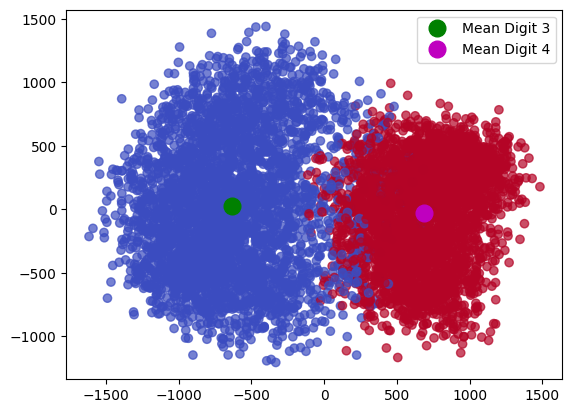

In [ ]:
mu_c_3 = np.mean(z_train[y_train == 3], axis=0)
mu_c_4 = np.mean(z_train[y_train == 4], axis=0)

plt.scatter(z_train[:, 0], z_train[:, 1], c=y_train, cmap="coolwarm", alpha=0.7)

plt.plot(mu_c_3[0], mu_c_3[1], 'go', markersize=12, label='Mean Digit 3')
plt.plot(mu_c_4[0], mu_c_4[1], 'mo', markersize=12, label='Mean Digit 4')
plt.legend()
plt.show()

In [ ]:
distance_3 = np.linalg.norm(z_test - mu_c_3, axis=1)
distance_4 = np.linalg.norm(z_test - mu_c_4, axis=1)
y_pred_distance = np.where(distance_3 < distance_4, 3, 4).astype(int)

accuracy = np.mean(y_pred_distance == y_test)
print(f"Accuracy using Nearest Mean Classifier: {accuracy:.4f}")

TP = np.sum((y_pred_distance == 4) & (y_test == 4))
TN = np.sum((y_pred_distance == 3) & (y_test == 3))
FP = np.sum((y_pred_distance == 4) & (y_test == 3))
FN = np.sum((y_pred_distance == 3) & (y_test == 4))
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
print(f"Precision using Nearest Mean Classifier: {precision:.4f}")
print(f"Recall using Nearest Mean Classifier: {recall:.4f}")
print_confusion_matrix([[TP, FP], [FN, TN]])

Accuracy using Nearest Mean Classifier: 0.9751
Precision using Nearest Mean Classifier: 0.9565
Recall using Nearest Mean Classifier: 0.9952
Confusion Matrix:
                    Predicted Positive   Predicted Negative
Actual Positive      836                  4
Actual Negative      38                  807


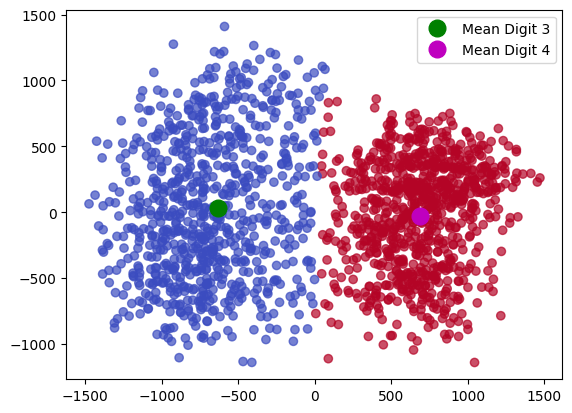

In [ ]:
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_pred_distance, cmap="coolwarm", alpha=0.7)
plt.plot(mu_c_3[0], mu_c_3[1], 'go', markersize=12, label='Mean Digit 3')
plt.plot(mu_c_4[0], mu_c_4[1], 'mo', markersize=12, label='Mean Digit 4')
plt.legend()
plt.title('Nearest Mean Classifier Predictions on Test Set')
plt.show()

In [35]:
def filter_data_by_digit(path, digit1, digit2):
    df = pd.read_csv(path)

    x_features = df.iloc[:, 1:].values
    y_labels = df.iloc[:, 0].values

    mask = (y_labels == digit1) | (y_labels == digit2)
    x_filtered = x_features[mask]
    y_filtered = y_labels[mask]

    return x_filtered, y_filtered

def split_data(x, y, train_ratio=0.8):
    n_train = int(len(y) * train_ratio)
    idx = np.arange(len(y))
    rng.shuffle(idx)
    train_idx = idx[:n_train]
    test_idx = idx[n_train:]

    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    return x_train, y_train, x_test, y_test

def center_data(x_train, x_test):
    mean_train = np.mean(x_train, axis=0)
    x_train_c = x_train - mean_train
    x_test_c = x_test - mean_train
    return x_train_c, x_test_c

def project_onto_pcs(x_train_c, x_test_c, k):
    u, s, vt = np.linalg.svd(x_train_c, full_matrices=False)
    v_k = vt[:k]
    z_train = x_train_c @ v_k.T
    z_test = x_test_c @ v_k.T
    return z_train, z_test

def linear_classifier(z_train, y_train, z_test, digit1, digit2):
    x_train = np.hstack((z_train, np.ones((z_train.shape[0], 1))))
    y_binary = (y_train == digit2).astype(int).reshape(-1, 1)

    theta, _, _ = train_sgd(
        bce_loss, grad_bce_loss,
        x_train, y_binary,
        lr=1e-3,
        epochs=2000,
        batch_size=32,
        full_loss=True
    )
    x_test = np.hstack((z_test, np.ones((z_test.shape[0], 1))))
    y_prob = sigmoid(x_test @ theta)
    y_pred = np.where(y_prob.ravel() >= 0.5, digit2, digit1).astype(int)

    return y_pred, theta

def centroid_classifier(z_train, y_train, z_test, digits):
    mu_c_0 = np.mean(z_train[y_train == digits[0]], axis=0)
    mu_c_1 = np.mean(z_train[y_train == digits[1]], axis=0)

    distance_0 = np.linalg.norm(z_test - mu_c_0, axis=1)
    distance_1 = np.linalg.norm(z_test - mu_c_1, axis=1)
    y_pred = np.where(distance_0 < distance_1, digits[0], digits[1]).astype(int)

    return y_pred, mu_c_0, mu_c_1

def compare_classifiers(path, digit1, digit2, k):
    x, y = filter_data_by_digit(path, digit1, digit2)
    x_train, y_train, x_test, y_test = split_data(x, y)
    x_train_c, x_test_c = center_data(x_train, x_test)
    z_train, z_test = project_onto_pcs(x_train_c, x_test_c, k)

    y_pred_linear, theta = linear_classifier(z_train, y_train, z_test, digit1, digit2)
    accuracy_linear = np.mean(y_pred_linear == y_test)

    # 获取z_test的数据范围
    x_min, x_max = z_test[:, 0].min(), z_test[:, 0].max()
    x_margin = (x_max - x_min) * 0.05

    # 使用z_test的范围来绘制决策边界
    x_value = np.array([x_min - x_margin, x_max + x_margin])
    y_value = -(theta[2] + theta[0] * x_value) / theta[1]

    linear_misclassified = y_pred_linear != y_test
    linear_misclassified_points = z_test[linear_misclassified]

    y_pred_centroid, mu_c_0, mu_c_1 = centroid_classifier(z_train, y_train, z_test, np.array([digit1, digit2]))
    accuracy_centroid = np.mean(y_pred_centroid == y_test)
    centroid_misclassified = y_pred_centroid != y_test
    centroid_misclassified_points = z_test[centroid_misclassified]

    both_misclassified_mask = linear_misclassified & centroid_misclassified
    both_misclassified = z_test[both_misclassified_mask]

    linear_misclassified_points_only = z_test[linear_misclassified & ~both_misclassified_mask]
    centroid_misclassified_points_only = z_test[centroid_misclassified & ~both_misclassified_mask]

    print(f"Linear Classifier Accuracy: {accuracy_linear:.4f}")
    print(f"Centroid Classifier Accuracy: {accuracy_centroid:.4f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test, cmap="viridis", alpha=0.7)
    plt.plot(x_value, y_value, 'r--', label='Decision Boundary (Linear Classifier)')
    plt.plot(mu_c_0[0], mu_c_0[1], 'go', markersize=12, label=f'Mean Digit {digit1}')
    plt.plot(mu_c_1[0], mu_c_1[1], 'mo', markersize=12, label=f'Mean Digit {digit2}')
    if len(linear_misclassified_points_only) > 0:
        plt.scatter(linear_misclassified_points_only[:, 0], linear_misclassified_points_only[:, 1], facecolors='red', marker='o', edgecolors='black', s=100, label='Misclassified by Linear')
    if len(centroid_misclassified_points_only) > 0:
        plt.scatter(centroid_misclassified_points_only[:, 0], centroid_misclassified_points_only[:, 1], facecolors='red', marker='d', edgecolors='black', s=100, label='Misclassified by Centroid')
    if len(both_misclassified) > 0:
        plt.scatter(both_misclassified[:, 0], both_misclassified[:, 1], facecolors='red', marker='*', edgecolors='black', s=100, label='Misclassified by Both')

    # 设置坐标轴范围只根据z_test的数据
    y_min, y_max = z_test[:, 1].min(), z_test[:, 1].max()
    y_margin = (y_max - y_min) * 0.05
    plt.xlim([x_min - x_margin, x_max + x_margin])
    plt.ylim([y_min - y_margin, y_max + y_margin])

    plt.legend()
    plt.title(f'Classifier Comparison for Digits {digit1} and {digit2}')
    plt.show()


Linear Classifier Accuracy: 0.9763
Centroid Classifier Accuracy: 0.9703


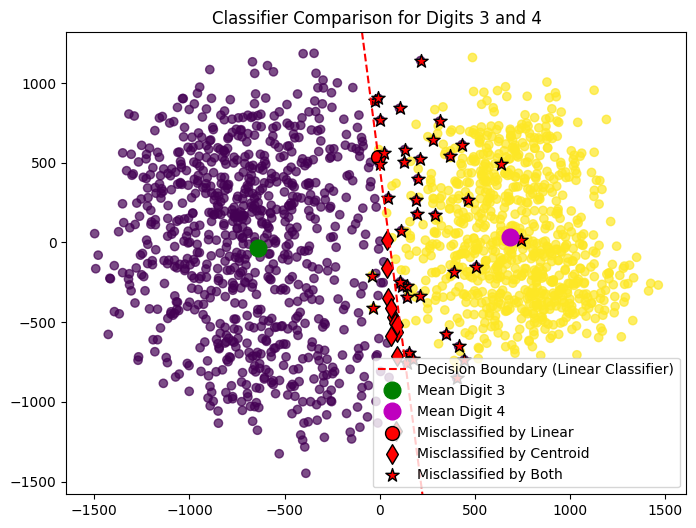

In [36]:
compare_classifiers('train.csv', 3, 4, k=2)

Linear Classifier Accuracy: 0.9675
Centroid Classifier Accuracy: 0.9637


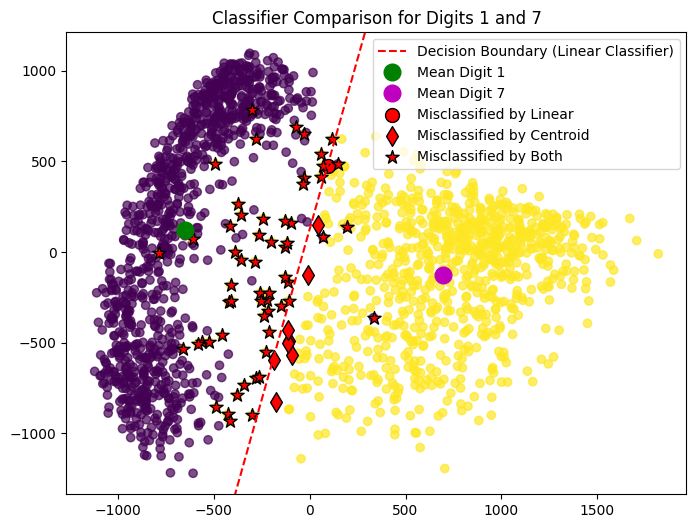

In [37]:
compare_classifiers('train.csv', 1, 7, k=2)

Linear Classifier Accuracy: 0.7545
Centroid Classifier Accuracy: 0.7710


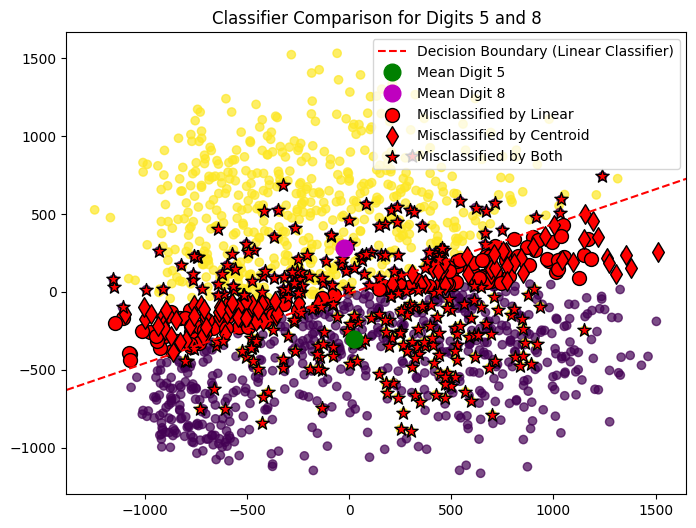

In [40]:
compare_classifiers('train.csv', 5, 8, k=2)

Linear Classifier Accuracy: 0.8259
Centroid Classifier Accuracy: 0.8974


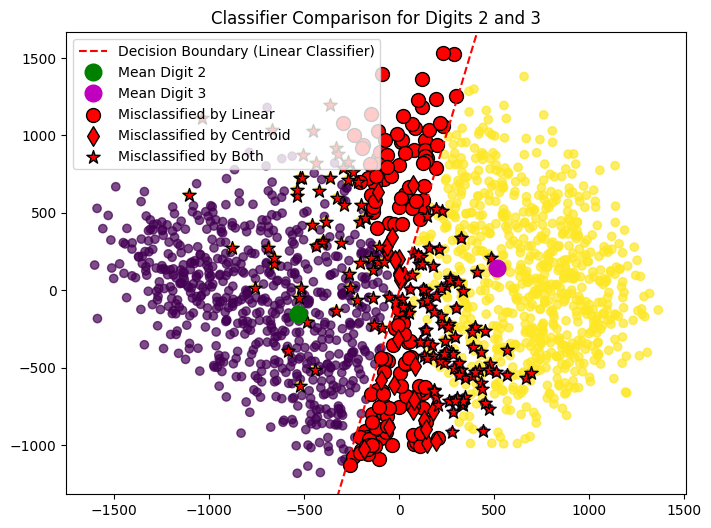

In [39]:
compare_classifiers('train.csv', 2, 3, k=2)